In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)


def load_mnist(path, kind='train'):
    """
    Load MNIST data from 'path'
    """
    labels_path = os.path.join(path,
                               '{}-labels-idx1-ubyte'.format(kind))
    images_path = os.path.join(path,
                               '{}-images-idx3-ubyte'.format(kind))
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(
                             len(labels), 784)
    
    return images, labels


class MNISTDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = torch.Tensor(images)
        self.targets = torch.Tensor(targets)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index].reshape(28,28)
        target = self.targets[index]

        if self.transform:
            image = self.transform(image)

        return image, target


def image_sample(inp, figsize=(20,20)):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(
        inp,
        interpolation='nearest'
    )

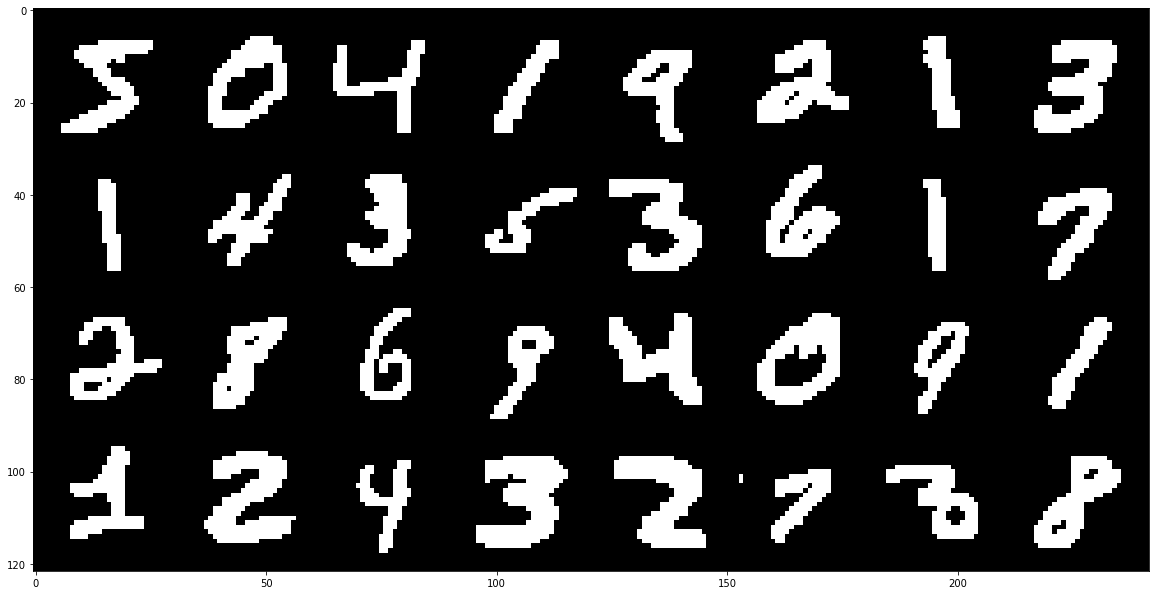

In [2]:
mnist_dir=os.path.join(os.environ["HOME"], "s3buckets", "mnist")

## training
# images
X_train, y_train = load_mnist(
    path=mnist_dir,
    kind="train"
)

train_data = MNISTDataset(
    images=X_train,
    targets=y_train,
)

train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=False,
    # sampler=weighted_sampler
)

# visualize image batch grid
inputs, classes = next(iter(train_data_loader))
out = torchvision.utils.make_grid(inputs.unsqueeze(1))

image_sample(out)

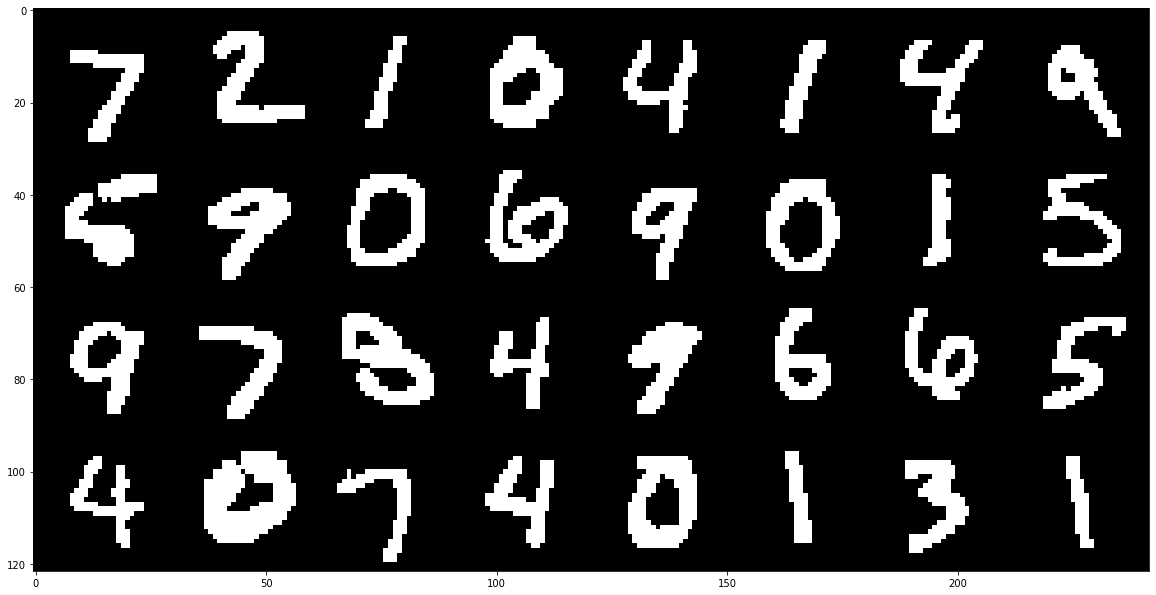

In [3]:
mnist_dir=os.path.join(os.environ["HOME"], "s3buckets", "mnist")

## validing
# images
X_valid, y_valid = load_mnist(
    path=mnist_dir,
    kind="t10k"
)

valid_data = MNISTDataset(
    images=X_valid,
    targets=y_valid,
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=32,
    shuffle=False,
    # sampler=weighted_sampler
)

# visualize image batch grid
inputs, classes = next(iter(valid_data_loader))
out = torchvision.utils.make_grid(inputs.unsqueeze(1))

image_sample(out)